# Train a Neural Network to Detect Breast MRI Tumors with PyTorch
#A practical tutorial for medical image analysis
 https://towardsdatascience.com/train-a-neural-network-to-detect-breast-mri-tumors-with-pytorch-250a02be7777
 code by Nick Konz (minor) ajustments by Stefan Seidel

 Literature:
 Saha, A., Harowicz, M.R., Grimm, L.J., Kim, C.E., Ghate, S.V., Walsh, R. and Mazurowski, M.A., 2018. 
 A machine learning approach to radiogenomics of breast cancer: a study of 922 subjects and 529 DCE-MRI features. 
 British journal of cancer, 119(4), pp.508–516. (A free version of this paper is available here: PMC6134102)

In [1]:
!pip install pandas

In [2]:
!pip install pydicom

In [3]:
!pip install torch

In [4]:
!pip install torchvision

In [5]:
# first, load some necessary libraries
import pandas as pd
import numpy as np
import os
import pydicom
from tqdm import tqdm
from skimage.io import imsave
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.io import imread

In [6]:
!pip install scikit-image

In [7]:
# directory where our .png data is (created in the previous post)
data_dir = 'data/png_out'
# length in pixels of size of image once resized for the network
img_size = 128 

Datasets

First, we must define our own Dataset for the DBC dataset, called DBCDataset. In summary, the important methods defined in DBCDataset are:

    - the create_labels() method assigns an easily-accessible label to each image in the dataset,
    - the normalize() method normalizes images to the pixel value range [0,255], as it's 
            important to standardize data for deep learning,
    - the __getitem__() method is required for Datasets, and describes how data is obtained from the 
            dataset with an index (or indices)

Check out the code block below, where comments are added to explain each step.

In [8]:
class DBCDataset(Dataset):
    def __init__(self):
        self.data_dir = data_dir
        self.img_size = img_size
        
        # assign labels to data within this Dataset
        self.labels = None
        self.create_labels()

    def create_labels(self):
        # create and store a label (positive/1 or negative/0 for each image)
        # each label is the tuple: (img filename, label number (0 or 1))
        labels = []
        print('building DBC dataset labels.')
        # iterate over each class
        for target, target_label in enumerate(['neg', 'pos']):
            case_dir = os.path.join(self.data_dir, target_label)
            # iterate over all images in the class/case type
            for fname in os.listdir(case_dir):
                if '.png' in fname:
                    fpath = os.path.join(case_dir, fname)
                    labels.append((fpath, target))
            
        self.labels = labels

                 
    def normalize(self, img):
        # normalize image pixel values to range [0, 255]
        # img expected to be array
                 
        # convert uint16 -> float
        img = img.astype(float) * 255. / img.max()
        # convert float -> unit8
        img = img.astype(np.uint8)
        
        return img
    
    def __getitem__(self, idx):
        # required method for accessing data samples
        # returns data with its label
        fpath, target  = self.labels[idx]
        
        # load img from file (png or jpg)
        img_arr = imread(fpath, as_gray=True)
        
        # normalize image
        img_arr = self.normalize(img_arr)
        
        # convert to tensor (PyTorch matrix)
        data = torch.from_numpy(img_arr)
        data = data.type(torch.FloatTensor) 
       
        # add image channel dimension (to work with neural network)
        data = torch.unsqueeze(data, 0)
        
        # resize image
        data = transforms.Resize((self.img_size, self.img_size))(data)
        
        return data, target

    def __len__(self):
        # required method for getting size of dataset
        return len(self.labels)

In [9]:
# create an instance of the dataset:
dataset = DBCDataset()
print(len(dataset))

building DBC dataset labels.
5200


Training, Validation and Test sets

Training:    provide model with input of examples how to make predictions

Validation:  used to estimat how well the model perfomrs at predicting labels for new data ( generalisation of  models) -> save model when validation error is at it's lowest. It is also possible to set hyperparameters or settings for the training algorithm that are not learned form the training set
    
Test:        estimate generalisation ability of the NN on new data (must be seperate from the validation set because   the validation set itself was used to select the final model, and we want an unbiase estimate of the generalisation ability.

With a dataset size of 2600 + 2600 = 5200, a typical set of percentages for splitting the dataset into training/validation/testing could be something like 80%/10%/10%, which results in a training set of size 4160, and validation and testing set sizes of 520, each. Practically, we can extract these subsets from our dataset with the useful function torch.utils.data.random_split(), which randomly splits up the full dataset into subsets:


In [10]:
train_fraction = 0.8
validation_fraction = 0.1
test_fraction = 0.1
dataset_size = len(dataset)
[print(dataset_size)]

num_train = int(train_fraction * dataset_size)
num_validation = int(validation_fraction * dataset_size)
num_test = int(test_fraction * dataset_size)
print(num_train, num_validation, num_test)

train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(
                                 dataset, [num_train, num_validation, num_test])

5200
4160 520 520


**Create dataloader to train batches**

In [11]:
# GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('running on {}'.format(device))

running on cpu


In [12]:
train_batchsize = 100 # depends on your computation hardware
eval_batchsize = 10 # can be small due to small dataset size
train_loader = DataLoader(train_dataset, 
                                     batch_size=train_batchsize, 
                                     shuffle=True
                                     # images are loaded in random order
                                                )
                                                
validation_loader = DataLoader(validation_dataset, 
                        batch_size=eval_batchsize)

test_loader = DataLoader(test_dataset, 
                        batch_size=eval_batchsize)

In [13]:
# set random seeds for reproducibility
import random
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

**Loading a neural network**

Convolutional neural network are designed to learn to detect the spatial patterns found in images. 
Here a very popular modern neural network architecture called "Residual network (ResNet)" is used.

In [14]:
# import libraries
from torchvision.models import resnet18
from torch import nn

In [15]:
net = resnet18()

ResNets are designed to work with color, three-channel images. However, our MRI slices are one-channel, so we will need to modify our net to take one-channel inputs. This can be accomplished by modifying the input layer of net as:

In [16]:
net.conv1 = nn.Conv2d(1,                     # in_channel 
                      64,                    # out_channel  
                      kernel_size=(7, 7),    # is empirically?
                      stride=(2, 2),         # controls stride for cross-correlation
                      padding=(3, 3),        # controls amount of padding applied to input
                      bias=False)            # do not add a learnable bias to the output 

In [17]:
# load net to computation device
net = net.to(device)

**Setting up for training**

Define parameters for "stochastic gradient descent" (ajustment over the "epoch" over the the training set in order to perform better)

Define prediction error (="loss")

In [18]:
criterion = nn.CrossEntropyLoss()

Define error minimization:
    we use "stochastic gradient descent" and define the "learning rate"(= lr). The lr is a fixed constant that determines the approximate size of adjustments made to parameter during learning. A good chioce of learning rate can vary depending o the task. for now we will use "lr=0.001"

In [19]:
error_minimizer = torch.optim.SGD(net.parameters(), lr=0.001)

finally lets set the number of training epochs(passes over the entire training set) to 100 (I set it to 10 as my hardware has a weak performance)

In [20]:
# set to 200 for real application; 10 used for test purpose
epochs = 10 

**Train and validate the model**

We now have everything that we need to train our classification model. As mentioned earlier, on each training epoch we can evaluate the model on the validation dataset to estimate how well it will perform on unseen data. Then, we save our final trained model as the model found to have the best performance/classification accuracy on the validation set during training.

To do this in practice, we can create a copy of our training model net, and save it as a separate network net_final. Let's go ahead and initialize that:

In [21]:
from copy import deepcopy
net_final = deepcopy(net)

Finally, we can create and run our training loop, with everything that we discussed earlier, in the code below (with comments at each step). In practice, we will use classification accuracy as our measure of prediction error, i.e., the percentage of images in the given dataset that are classified correctly by the network. One subtlety to deal with is that the network actually outputs probabilities for the input image being in each class. As such, the single predicted class is just given by the highest probability class.

We can also store our accuracy vs. epoch data for the training and validation sets, in order to observe how the model evolves through training.

Alright, let’s go ahead and train our model! This may take some time, depending on the strength of your computation device. I’ve also included some code to log each step of training.



In [22]:
best_validation_accuracy = 0. 
# used to pick the best-performing model on the validation set

# for training visualization later
train_accs = []
val_accs = []

# training loop
for epoch in range(epochs):
	# set network to training mode, so that its parameters can be changed
	net.train()

	# print training info
	print("### Epoch {}:".format(epoch))


	# statistics needed to compute classification accuracy:
	# the total number of image examples trained on
	total_train_examples = 0

	# the number of examples classified correctly
	num_correct_train = 0

	# iterate over the training set once
	for batch_index, (inputs, targets) in tqdm(enumerate(train_loader), 
	                          total=len(train_dataset)//train_batchsize):
		# load the data onto the computation device.
		# inputs are a tensor of shape: 
		#   (batch size, number of channels, image height, image width).
		# targets are a tensor of one-hot-encoded class labels for the inputs, 
		#   of shape (batch size, number of classes)
		# in other words, 
		inputs = inputs.to(device)
		targets = targets.to(device)

		# reset changes (gradients) to parameters
		error_minimizer.zero_grad()

		# get the network's predictions on the training set batch
		predictions = net(inputs)

		# evaluate the error, and estimate 
		#   how much to change the network parameters
		loss = criterion(predictions, targets)
		loss.backward()

		# change parameters
		error_minimizer.step()

		# calculate predicted class label
		# the .max() method returns the maximum entries, and their indices;
		# we just need the index with the highest probability, 
		#   not the probability itself.
		_, predicted_class = predictions.max(1)
		total_train_examples += predicted_class.size(0)
		num_correct_train += predicted_class.eq(targets).sum().item()

	# get results
	# total prediction accuracy of network on training set
	train_acc = num_correct_train / total_train_examples
	print("Training accuracy: {}".format(train_acc))
	train_accs.append(train_acc)



	# predict on validation set (similar to training set):
	total_val_examples = 0
	num_correct_val = 0

	# switch network from training mode (parameters can be trained) 
	#   to evaluation mode (parameters can't be trained)
	net.eval()

	with torch.no_grad(): # don't save parameter changes 
	 #                      since this is not for training
		for batch_index, (inputs, targets) in tqdm(enumerate(validation_loader), 
		                          total=len(validation_dataset)//eval_batchsize):
			inputs = inputs.to(device)
			targets = targets.to(device)
			predictions = net(inputs)

			_, predicted_class = predictions.max(1)
			total_val_examples += predicted_class.size(0)
			num_correct_val += predicted_class.eq(targets).sum().item()

	# get results
	# total prediction accuracy of network on validation set
	val_acc = num_correct_val / total_val_examples
	print("Validation accuracy: {}".format(val_acc))
	val_accs.append(val_acc)


	# Finally, save model if the validation accuracy is the best so far
	if val_acc > best_validation_accuracy:
		best_validation_accuracy = val_acc
		print("Validation accuracy improved; saving model.")
		net_final = deepcopy(net)

### Epoch 0:


42it [05:19,  7.61s/it]                        


Training accuracy: 0.3903846153846154


100%|██████████| 52/52 [00:25<00:00,  2.05it/s]


Validation accuracy: 0.5923076923076923
Validation accuracy improved; saving model.
### Epoch 1:


42it [04:13,  6.04s/it]                        


Training accuracy: 0.5764423076923076


100%|██████████| 52/52 [00:10<00:00,  4.78it/s]


Validation accuracy: 0.6076923076923076
Validation accuracy improved; saving model.
### Epoch 2:


42it [03:44,  5.35s/it]                        


Training accuracy: 0.6370192307692307


100%|██████████| 52/52 [00:10<00:00,  4.78it/s]


Validation accuracy: 0.6384615384615384
Validation accuracy improved; saving model.
### Epoch 3:


42it [03:29,  4.98s/it]                        


Training accuracy: 0.6973557692307693


100%|██████████| 52/52 [00:10<00:00,  4.73it/s]


Validation accuracy: 0.6923076923076923
Validation accuracy improved; saving model.
### Epoch 4:


42it [03:31,  5.05s/it]                        


Training accuracy: 0.7365384615384616


100%|██████████| 52/52 [00:11<00:00,  4.68it/s]


Validation accuracy: 0.6884615384615385
### Epoch 5:


42it [03:29,  4.98s/it]                        


Training accuracy: 0.7603365384615385


100%|██████████| 52/52 [00:11<00:00,  4.51it/s]


Validation accuracy: 0.698076923076923
Validation accuracy improved; saving model.
### Epoch 6:


42it [03:34,  5.10s/it]                        


Training accuracy: 0.7737980769230769


100%|██████████| 52/52 [00:10<00:00,  4.74it/s]


Validation accuracy: 0.7288461538461538
Validation accuracy improved; saving model.
### Epoch 7:


42it [03:29,  4.99s/it]                        


Training accuracy: 0.7932692307692307


100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


Validation accuracy: 0.7403846153846154
Validation accuracy improved; saving model.
### Epoch 8:


42it [03:29,  5.00s/it]                        


Training accuracy: 0.8055288461538461


100%|██████████| 52/52 [00:10<00:00,  4.75it/s]


Validation accuracy: 0.7442307692307693
Validation accuracy improved; saving model.
### Epoch 9:


42it [03:30,  5.00s/it]                        


Training accuracy: 0.8161057692307693


100%|██████████| 52/52 [00:10<00:00,  4.78it/s]

Validation accuracy: 0.7557692307692307
Validation accuracy improved; saving model.


Plot our model’s performance evolved over time, with a simple plot via matplotlib:

In [24]:
pip install matplotlib

     |████████████████████████████████| 11.8 MB 3.5 MB/s            
     |████████████████████████████████| 1.6 MB 143 kB/s            
     |████████████████████████████████| 299 kB 3.1 MB/s            
     |████████████████████████████████| 965 kB 5.9 MB/s            
Note: you may need to restart the kernel to use updated packages.


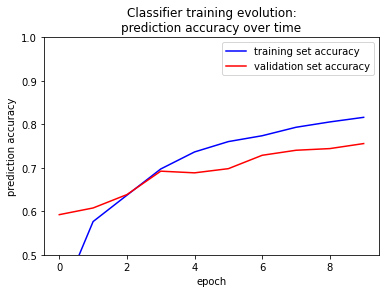

In [25]:
import matplotlib.pyplot as plt

epochs_list = list(range(epochs))

plt.figure()
plt.plot(epochs_list, train_accs, 'b-', label='training set accuracy')
plt.plot(epochs_list, val_accs, 'r-', label='validation set accuracy')
plt.xlabel('epoch')
plt.ylabel('prediction accuracy')
plt.ylim(0.5, 1)
plt.title('Classifier training evolution:\nprediction accuracy over time')
plt.legend()
plt.show()

The model obtained a validation accuracy of XX% once fully trained, which means that out of the validation set of X images, it correctly classified about Y of them as either cancerous or non-cancerous.

You may also notice that the model overfit to the training set. This could have been mitigated with some sort of regularization, but that is beyond the scope of this introductory tutorial.

This performance is good, but we will only know the true ability of the model to classify new data by evaluating it on the test set, as follows.

(5) Testing your best model

Now that our model is trained, how well does it do on the test set? We can test this with the following code, where I also show a few classification examples; this is very similar to how we evaluated on the validation set.
A Word on Measuring a Classifier’s Performance in Medical Image Analysis

In medical image analysis, it is common to report further performance metrics than solely classification accuracy, to better analyze how the classifier is doing. A false positive (FP) is when a classifier misclassifies a negative (cancer-free) image as positive, and a true positive (TP) is when a positive image is correctly classified. Let’s estimate these as well in our code:

Example Images:


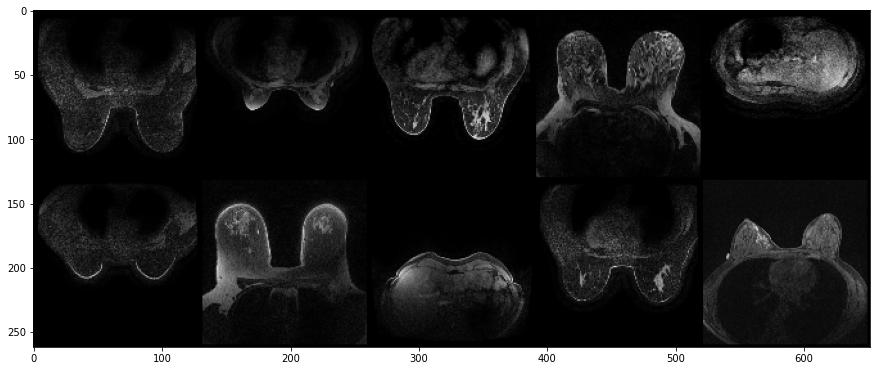

Target labels:
[0, 1, 1, 1, 0, 0, 1, 0, 0, 1]
Classifier predictions:
[1, 0, 1, 1, 0, 1, 1, 0, 1, 1]
Test set accuracy: 0.7673076923076924
202 true positive classifications, 71 false positive classifications


In [27]:
# for data visualization
from torchvision.utils import make_grid

# helper function for plotting a batch of images
def plot_imgbatch(imgs):
    imgs = imgs.cpu()
    imgs = imgs.type(torch.IntTensor)
    plt.figure(figsize=(15, 3*(imgs.shape[0])))
    grid_img = make_grid(imgs, nrow=5)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

total_test_examples = 0
num_correct_test = 0

# true and false positive counts
false_pos_count = 0
true_pos_count = 0

# visualize a random batch of data with examples
num_viz = 10
viz_index = random.randint(0, len(test_dataset)//eval_batchsize)

# see how well the final trained model does on the test set
with torch.no_grad(): # don't save parameter gradients/changes since this is not for model training
		for batch_index, (inputs, targets) in enumerate(test_loader):
			# make predictions
			inputs = inputs.to(device)
			targets = targets.to(device)
			predictions = net_final(inputs)

			# compute prediction statistics
			_, predicted_class = predictions.max(1)
			total_test_examples += predicted_class.size(0)
			num_correct_test += predicted_class.eq(targets).sum().item()
            
			# thanks to 
			#   https://gist.github.com/the-bass/cae9f3976866776dea17a5049013258d
			confusion_vector = predicted_class / targets
			num_true_pos = torch.sum(confusion_vector == 1).item()
			num_false_pos = torch.sum(confusion_vector == float('inf')).item()
            
			true_pos_count += num_true_pos
			false_pos_count += num_false_pos

			# plot predictions
			if batch_index == viz_index:
				print('Example Images:')
				plot_imgbatch(inputs[:num_viz])
				print('Target labels:')
				print(targets[:num_viz].tolist())
				print('Classifier predictions:')
				print(predicted_class[:num_viz].tolist())



# get total results
# total prediction accuracy of network on test set
test_acc = num_correct_test / total_test_examples
print("Test set accuracy: {}".format(test_acc))
print("{} true positive classifications, {} false positive classifications".format(true_pos_count, false_pos_count))

Discussion

When designing automated approaches for safety-critical applications such as medical imaging, it is essential to examine possible risks and limitations. An example of this is the possibility of false positives: if a cancer detection model like this one was used clinically, a positive detection would immediately warrant further study of the patient, so a false positive could be misleading. A related possibility is that of false negatives: where a tumor is completely missed by the detection model. While our model had a high prediction accuracy overall, it was not perfect, and so should not be completely trusted for all diagnostic decisions. This is why a common paradigm for the development goal of computer-assisted diagnosis (CAD) devices is to assist, not replace, the radiologist.

It is also important to remember that models trained with deep learning are completely data-driven: they learn exactly according to how the training set was labeled. For example, I chose to label the dataset in this tutorial by assigning each 2D slice of a 3D MRI scan to a class of either positive (containing a breast tumor annotation) or negative. However, even if some slices from a 3D scan are found to be negative, that does not indicate that the entire scan/patient is negative for cancer: there could be other slices in the scan that are positive. This is an example of how all predictions made by CAD systems should be stated clearly and quantifiably.

There are many possible additions that could be made to improve this detection model. As we saw in the training evolution plot in section (4), it appears that our model overfit to the training set (indicated by the gap between training accuracy and validation accuracy). This could be mitigated or prevented with a number of techniques; see this tutorial for a good introduction to how to do this in PyTorch. Another improvement that we could make would be to train our model not to classify each 2D MRI slice as possessing a tumor somewhere, but to precisely locate any possible tumors within slices; a task known as object detection in computer vision. I did not explore that in this post because object detection is a considerably more nuanced problem than classification, but it would certainly be possible with our dataset because it contains tumor location labels/bounding boxes. A good starting point could be the PyTorch implementation of the Faster R-CNN object detection model.m

Conclusion

In this tutorial, it was showen how to train a breast MRI classification model via deep learning with PyTorch, on a DBC-MRI dataset.